# Imports

In [1]:
import os
import numpy as np
import torch
import pydicom
import matplotlib.pyplot as plt
from tcia_utils import nbia
from monai.bundle import ConfigParser, download
from monai.transforms import (LoadImage, LoadImaged, Orientation, Orientationd, 
                              EnsureChannelFirst, EnsureChannelFirstd, Compose)
from rt_utils import RTStructBuilder
from scipy.ndimage import label, measurements
import json

# Parameters

In [2]:
CWD = './Data'
CART_NAME = "nbia-56561691129779503"

# Download data

The download location is:

In [3]:
cart_data = nbia.getSharedCart(CART_NAME)
df = nbia.downloadSeries(cart_data, format="df", path=CWD)

2023-10-13 21:56:25,524:INFO:Calling... https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName with parameters {'name': 'nbia-56561691129779503'}
2023-10-13 21:56:28,093:INFO:Downloading 1 Series Instance UIDs (scans).
2023-10-13 21:56:30,373:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668 already downloaded.
2023-10-13 21:56:30,373:INFO:Downloaded 0 out of 1 Series Instance UIDs (scans).
0 failed to download.
1 previously downloaded.


In [4]:
df

,Series UID,Collection,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Modality,SOP Class UID,Number of Images,File Size,Series Number,License Name,License URL,Annotation Size
0,1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195...,CPTAC-SAR,https://doi.org/10.7937/TCIA.2019.9bt23r95,C3N-00875,1.3.6.1.4.1.14519.5.2.1.3320.3273.530366014057...,PETWHOLEBODYLONGLD90 Adult,11-12-1999,CT WB 3.0 B30f,CT,1.2.840.10008.5.1.4.1.1.2,975,514630252,4.000000,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,0


In [5]:
CT_FOLDER = f"{CWD}/{df.iloc[0]['Series UID']}"

## Loading the image with pydicom

In [6]:
def plotCtImage(image_name: str):
    ds = pydicom.read_file(f"{CT_FOLDER}/{image_name}")
    image = ds.pixel_array
    # Image is rescaled into houndsfield units
    return ds.RescaleSlope * image + ds.RescaleIntercept

In [7]:
image = plotCtImage("1-394.dcm")

In [8]:
image.dtype

dtype('float64')

In [9]:
def plotCtImage(image: np.ndarray, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.pcolormesh(image, cmap='Greys_r')
    plt.colorbar(label='HU')
    plt.axis('off')
    plt.show()

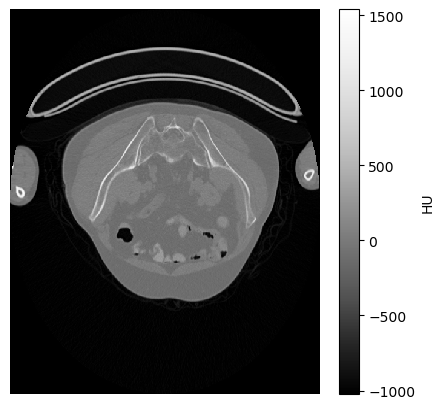

In [10]:
plotCtImage(image)

The unit -1000 refers to air. 

## Loading the image with monai

The monai package is very common in medical research. It uses Pytorch.

In [11]:
image_loader = LoadImage(image_only=True)

In [12]:
ct = image_loader(CT_FOLDER)

In [13]:
ct.meta

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '00200032': {'vr': 'DS', 'Value': [-249.51171875, -401.01171875, 1937.0]},
 'spacing': array([0.9765625, 0.9765625, 2.       ]),
 'lastImagePositionPatient': array([-249.51171875, -401.01171875,  -11.        ]),
 spatial_shape: (512, 512, 975),
 space: RAS,
 original_affine: array([[-9.76562500e-01,  0.00000000e+00,  0.00000000e+00,
          2.49511719e+02],
        [ 0.00000000e+00, -9.76562500e-01,  0.00000000e+00,
          4.01011719e+02],
        [ 0.00000000e+00,  0.00000000e+00, -2.00000000e+00,
          1.93700000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 affine: tensor([[-9.7656e-01,  0.0000e+00,  0.0000e+00,  2.4951e+02],
         [ 0.0000e+00, -9.7656e-01,  0.0000e+00,  4.0101e+02],
         [ 0.0000e+00,  0.0000e+00, -2.0000e+00,  1.9370e+03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
        dtype=torch.float64),
 original_chann

In [14]:
ct_coronal_slice = ct[:, 256].cpu().numpy().T

In [15]:
ct_coronal_slice.shape

(975, 512)

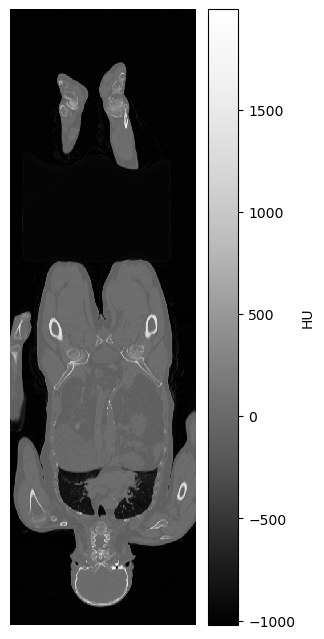

In [16]:
plotCtImage(ct_coronal_slice, figsize=(3, 8))

This is orientated the wrong way so we add some more transforms.

In [17]:
channel_transform = EnsureChannelFirst()

In [18]:
ct = channel_transform(ct)

In [19]:
ct.shape

torch.Size([1, 512, 512, 975])

In [20]:
ct_coronal_slice = ct[:, :, 256].cpu().numpy()[0].T

In [21]:
ct_coronal_slice.shape

(975, 512)

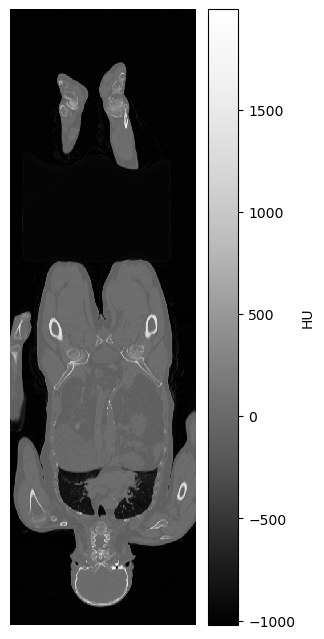

In [22]:
plotCtImage(ct_coronal_slice, figsize=(3, 8))

Now we add orientation to the ct scan as well.

In [23]:
orientation_transform = Orientation(axcodes=('LPS'))

In [24]:
ct = orientation_transform(ct)

In [25]:
ct_coronal_slice = ct[:, :, 256].cpu().numpy()[0].T

We see the liver on the left side and the heart leaning to the right. This is because we are looking from the doctor's perspective.

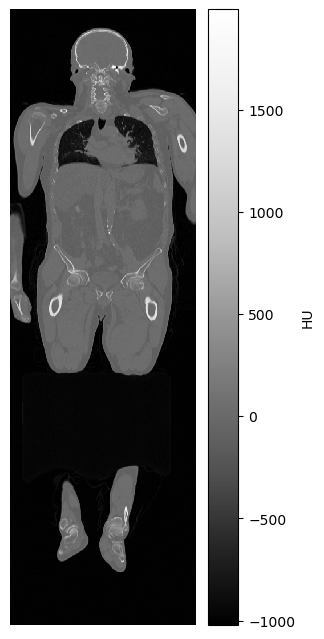

In [26]:
plotCtImage(ct_coronal_slice, figsize=(3, 8))

In [27]:
data = {"image": CT_FOLDER, "meta": {}}

In [28]:
preprocessing_pipeline = Compose([
    LoadImaged(keys='image', image_only=True),
    EnsureChannelFirstd(keys='image'),
    Orientationd(keys='image', axcodes='LPS')
])

In [29]:
ct = preprocessing_pipeline(data)

In [30]:
ct['image'].shape

torch.Size([1, 512, 512, 975])

In [31]:
ct_coronal_slice = ct['image'][:, :, 256].cpu().numpy().squeeze(0).T

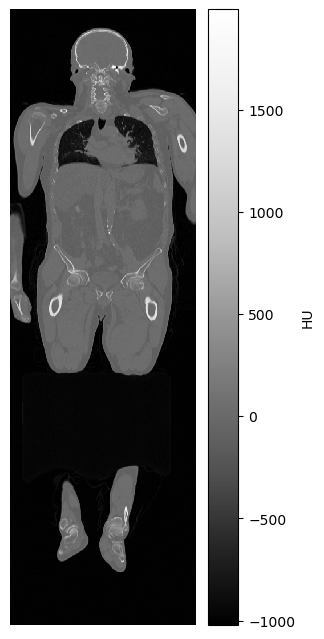

In [32]:
plotCtImage(ct_coronal_slice, figsize=(3, 8))

# Create a model

We can get a model from the monai model zoo.

In [33]:
MODEL_NAME = "wholeBody_ct_segmentation"
MODEL_FILE = "model_lowres.pt"

In [34]:
download(name=MODEL_NAME, bundle_dir=CWD)

2023-10-13 21:57:25,762 - INFO - --- input summary of monai.bundle.scripts.download ---
2023-10-13 21:57:25,769 - INFO - > name: 'wholeBody_ct_segmentation'
2023-10-13 21:57:25,769 - INFO - > bundle_dir: './Data'
2023-10-13 21:57:25,772 - INFO - > source: 'github'
2023-10-13 21:57:25,776 - INFO - > remove_prefix: 'monai_'
2023-10-13 21:57:25,778 - INFO - > progress: True
2023-10-13 21:57:25,779 - INFO - ---




wholeBody_ct_segmentation_v0.1.9.zip: 133MB [02:51, 812kB/s]                                                           

2023-10-13 22:00:18,873 - INFO - Downloaded: Data\wholeBody_ct_segmentation_v0.1.9.zip


2023-10-13 22:00:18,876 - INFO - Expected md5 is None, skip md5 check for file Data\wholeBody_ct_segmentation_v0.1.9.zip.
2023-10-13 22:00:18,880 - INFO - Writing into directory: Data.


## Load config

We edit the inference.json of the downloaded model.
* Since the model is predicting on voxels, we use the smaller model to downsample the image.
* Even with the smaller image, a lot of GPU RAM is needed, so we change the device from cuda if cuda is available or cpu to just cpu. (This happens in two places)
* We also change the output dir to `./Data/mask`.

In [45]:
model_path = f"{CWD}/{MODEL_NAME}/models/{MODEL_FILE}"
config_path = f"{CWD}/{MODEL_NAME}/configs/inference.json"

In [46]:
config = ConfigParser()
config.read_config(config_path)

## Preprocess Data

In [47]:
preprocessing = config.get_parsed_content("preprocessing")

In [48]:
data = preprocessing({'image': CT_FOLDER})

## Get a model

In [49]:
model = config.get_parsed_content("network")

In [50]:
model.load_state_dict(torch.load(model_path))
model.eval();

## Get inferer applies transformations 'on the fly'

We cannot apply the entire model on ct scans of different size, instead we infer on fixed chunks of 96 by 96 by 96.

In [51]:
inferer = config.get_parsed_content("inferer")

## Get post processing

In [52]:
postprocessing = config.get_parsed_content("postprocessing")

# Perform an inference

Make a prediction

In [53]:
with torch.no_grad():
    data['pred'] = inferer(data['image'].unsqueeze(0), network=model)

Remove batch dimension in image and prediction

In [54]:
data['pred'] = data['pred'][0]
data['image'] = data['image'][0]

Apply postprocessing to data (The CPU breaks at this point)

In [ ]:
data = postprocessing(data)
segmentation = torch.flip(data['pred'][0], dims=[2])
segmentation = segmentation.cpu().numpy()

In [ ]:
slice_idx = 250

In [ ]:
ct_coronal_slice = ct[0, :, slice_idx].cpu().numpy()
segmentation_coronal_slice = segmentation[:, slice_idx]

In [ ]:
def display_ct_image_and_segmentation(image, segmentation, figsize=(6, 8)):
    plt.subplots(1,2,figsize=(6,8))
    plt.subplot(121)
    plt.pcolormesh(image.T, cmap='Greys_r')
    plt.axis('off')
    plt.subplot(122)
    plt.pcolormesh(segmentation.T, cmap='nipy_spectral')
    plt.axis('off')
    plt.show()

In [ ]:
display_ct_image_and_segmentation(ct_coronal_slice, segmentation_coronal_slice)

Using these predicted segments, we can calculate the volume of the liver and so on.